Compute histogram of `tissue_general` values for "primary representations" of cells in the [CELLxGENE Census], using [TileDB-SOMA]:

[TileDB-SOMA]: https://github.com/single-cell-data/TileDB-SOMA
[CELLxGENE Census]: https://chanzuckerberg.github.io/cellxgene-census/

In [1]:
from concurrent.futures import ThreadPoolExecutor
from typing import Literal

import cellxgene_census
import numpy as np
import pandas as pd
import plotly.express as px
from somacore import AxisQuery
from tiledbsoma import Experiment, SOMATileDBContext
from utz import err
from utz.plots import plot

In [2]:
lts_census_versions = list(reversed(cellxgene_census.get_census_version_directory(lts=True).keys()))[:-1]
lts = lts_census_versions[-1]
lts_census_versions

['2023-05-15', '2023-07-25', '2023-12-15', '2024-07-01', '2025-01-30']

In [3]:
meas = "RNA"
layer = "raw"

mm = 'mus_musculus'
hs = 'homo_sapiens'
Species = Literal['homo_sapiens', 'mus_musculus']

def get_tissue_hist(
    census: str,
    species: Species,
    is_primary_data: bool,
):
    err(f"{census} {species} {is_primary_data}")
    exp_uri = f"s3://cellxgene-census-public-us-west-2/cell-census/{census}/soma/census_data/{species}"
    with Experiment.open(
        exp_uri,
        context=SOMATileDBContext(tiledb_config={
            "vfs.s3.no_sign_request": "true",
            "vfs.s3.region": "us-west-2"
        })
    ) as exp:
        query = exp.axis_query(
            meas,
            obs_query=AxisQuery(value_filter=f"is_primary_data == {is_primary_data}"),
        )
        n_obs = query.n_obs
        #print(f"{census}: {n_obs:,} total cells (primary representations only; {n_obs2:,} including non-primary representations)")
        tissue = query.obs(column_names=['tissue_general']).concat().to_pandas().tissue_general.rename('tissue')
        hist = tissue.value_counts().sort_values(ascending=False).rename('n_cells')
        return (
            hist
            .reset_index()
            .assign(
                census=census,
                species=species,
                is_primary=is_primary_data,
            )
            [['census', 'species', 'tissue', 'is_primary', 'n_cells']]
        )

In [4]:
%%time
with ThreadPoolExecutor(max_workers=8) as pool:
    df = pd.concat(pool.map(lambda t: get_tissue_hist(*t), [
        (census, species, is_primary_data)
        for census in lts_census_versions
        for species in [hs, mm]
        for is_primary_data in [True, False]
    ]), ignore_index=True)

df = df[df.n_cells > 0]
by = ['census', 'species', 'tissue', 'is_primary']
df = df.sort_values(by=by, ascending = [True] * (len(by)-1) + [False]).reset_index(drop=True)
df.to_parquet('census_tissue_hist.parquet', index=False)
df

2023-05-15 homo_sapiens True
2023-05-15 homo_sapiens False
2023-05-15 mus_musculus True
2023-05-15 mus_musculus False
2023-07-25 homo_sapiens True
2023-07-25 homo_sapiens False
2023-07-25 mus_musculus True
2023-07-25 mus_musculus False
2023-12-15 homo_sapiens True
2023-12-15 homo_sapiens False
2023-12-15 mus_musculus True
2023-12-15 mus_musculus False
2024-07-01 homo_sapiens True
2024-07-01 homo_sapiens False
2024-07-01 mus_musculus True
2024-07-01 mus_musculus False
2025-01-30 homo_sapiens True
2025-01-30 homo_sapiens False
2025-01-30 mus_musculus True
2025-01-30 mus_musculus False


CPU times: user 38.7 s, sys: 11.6 s, total: 50.3 s
Wall time: 16.7 s


,census,species,tissue,is_primary,n_cells
0,2023-05-15,homo_sapiens,abdomen,True,32635
1,2023-05-15,homo_sapiens,abdomen,False,26327
2,2023-05-15,homo_sapiens,abdominal wall,True,5154
3,2023-05-15,homo_sapiens,abdominal wall,False,4745
4,2023-05-15,homo_sapiens,adipose tissue,True,93970
...,...,...,...,...,...
795,2025-01-30,mus_musculus,urethra,False,55390
796,2025-01-30,mus_musculus,urinary bladder,True,11377
797,2025-01-30,mus_musculus,urinary bladder,False,22754
798,2025-01-30,mus_musculus,vasculature,True,906


In [5]:
import json

def jsonl_dump(recs, f, indent: str | int = '', commas: bool = False):
    n = len(recs)
    if isinstance(indent, int):
        indent = ' ' * indent
    for i, rec in enumerate(recs):
        if indent:
            f.write(indent)
        json.dump(rec, f)
        if commas and i + 1 < n:
            f.write(',')
        f.write('\n')

def json_compact_dump(recs, f, indent: int = 2):
    f.write('[\n')
    jsonl_dump(recs, f, indent=indent, commas=True)
    f.write(']\n')

In [6]:
recs = df.to_dict(orient="records")

with open("public/census_tissue_hist.json", 'w') as f:
    json_compact_dump(recs, f)

In [7]:
sc = (
    df
    .set_index(['species', 'census'])
    .sort_index()
)
sc.loc[('mus_musculus', '2025-01-30')]

tissue  is_primary   n_cells
species      census                                                  
mus_musculus 2025-01-30          adipose tissue        True    216896
             2025-01-30          adipose tissue       False    222637
             2025-01-30                   blood        True     90833
             2025-01-30             bone marrow        True     90225
             2025-01-30             bone marrow       False    109474
             2025-01-30                   brain        True   3506070
             2025-01-30                   brain       False    638294
             2025-01-30  central nervous system        True     65274
             2025-01-30                   colon        True      3509
             2025-01-30                   colon       False      3008
             2025-01-30                  embryo        True  11441546
             2025-01-30                  embryo       False  22882814
             2025-01-30         endocrine gland        True     85364
             2025-01-30         endocrine gland       False     56052
             2025-01-30          exocrine gland        True     15577
             2025-01-30          exocrine gland       False     31154
             2025-01-30                     eye        True    330784
             2025-01-30                     eye       False    269248
             2025-01-30                forelimb        True    164391
             2025-01-30                   heart        True    107499
             2025-01-30                   heart       False     36564
             2025-01-30                hindlimb        True     50676
             2025-01-30                  kidney        True    195450
             2025-01-30                  kidney       False     52120
             2025-01-30         large intestine        True     10198
             2025-01-30         large intestine       False     20396
             2025-01-30                   liver        True     26354
             2025-01-30                   liver       False     20306
             2025-01-30                    lung        True     97552
             2025-01-30                    lung       False     59516
             2025-01-30              lymph node        True     10889
             2025-01-30              lymph node       False      4083
             2025-01-30                  mucosa        True     12118
             2025-01-30             musculature        True    131109
             2025-01-30             musculature       False     69160
             2025-01-30          nervous system        True    271988
             2025-01-30          nervous system       False    224483
             2025-01-30               optic cup        True       146
             2025-01-30                   ovary        True     17408
             2025-01-30                   ovary       False     18293
             2025-01-30                pancreas        True    343448
             2025-01-30                pancreas       False     26181
             2025-01-30          prostate gland        True     37715
             2025-01-30          prostate gland       False     92420
             2025-01-30     reproductive system        True     93634
             2025-01-30     reproductive system       False     47317
             2025-01-30      respiratory system        True     11136
             2025-01-30      respiratory system       False     22272
             2025-01-30         skeletal system        True     15127
             2025-01-30            skin of body        True     65679
             2025-01-30            skin of body       False     27300
             2025-01-30         small intestine        True     22798
             2025-01-30         small intestine       False      2212
             2025-01-30                  spleen        True     39552
             2025-01-30                  spleen       False     79104
             2025-01-30                  testis    

In [8]:
def get_hist(species: Species = hs, census: str = lts):
    d = (
        sc
        .loc[(species, census)]
        .set_index('tissue')
        .pivot(columns='is_primary')
        .fillna(0)
        .astype(int)
    )
    d.columns = [ c[1] for c in d.columns ]
    d = pd.concat([ d[True], d[False] ], axis=1).sort_values(by=True, ascending=False)
    sums = d.sum()
    err(f'{species} {census}: {sums[True]:,} primary, {sums[False]:,} secondary, {sums.sum():,} total')
    return d

In [9]:
hsl = get_hist()
hsl

homo_sapiens 2025-01-30: 62,634,126 primary, 43,484,041 secondary, 106,118,167 total


,True,False
tissue,,
brain,20704756,17620420
blood,11220002,1439692
lung,5179194,3641044
eye,3812493,2647728
heart,2830068,2615274
breast,2637364,3177314
liver,1429379,1247562
kidney,1367163,991230
small intestine,1193263,442759


In [10]:
mml = get_hist(mm)
mml

mus_musculus 2025-01-30: 17,633,669 primary, 25,143,194 secondary, 42,776,863 total


,True,False
tissue,,
embryo,11441546,22882814
brain,3506070,638294
pancreas,343448,26181
eye,330784,269248
nervous system,271988,224483
adipose tissue,216896,222637
kidney,195450,52120
forelimb,164391,0
musculature,131109,69160


In [11]:
by = ['census', 'species', 'tissue', 'is_primary']
df.sort_values(by=by, ascending = [True] * (len(by)-1) + [False]).reset_index(drop=True)

,census,species,tissue,is_primary,n_cells
0,2023-05-15,homo_sapiens,abdomen,True,32635
1,2023-05-15,homo_sapiens,abdomen,False,26327
2,2023-05-15,homo_sapiens,abdominal wall,True,5154
3,2023-05-15,homo_sapiens,abdominal wall,False,4745
4,2023-05-15,homo_sapiens,adipose tissue,True,93970
...,...,...,...,...,...
795,2025-01-30,mus_musculus,urethra,False,55390
796,2025-01-30,mus_musculus,urinary bladder,True,11377
797,2025-01-30,mus_musculus,urinary bladder,False,22754
798,2025-01-30,mus_musculus,vasculature,True,906


Wrote plot JSON to census_tissue_hist_plot.json
Wrote plot image to census-tissue-hist.png


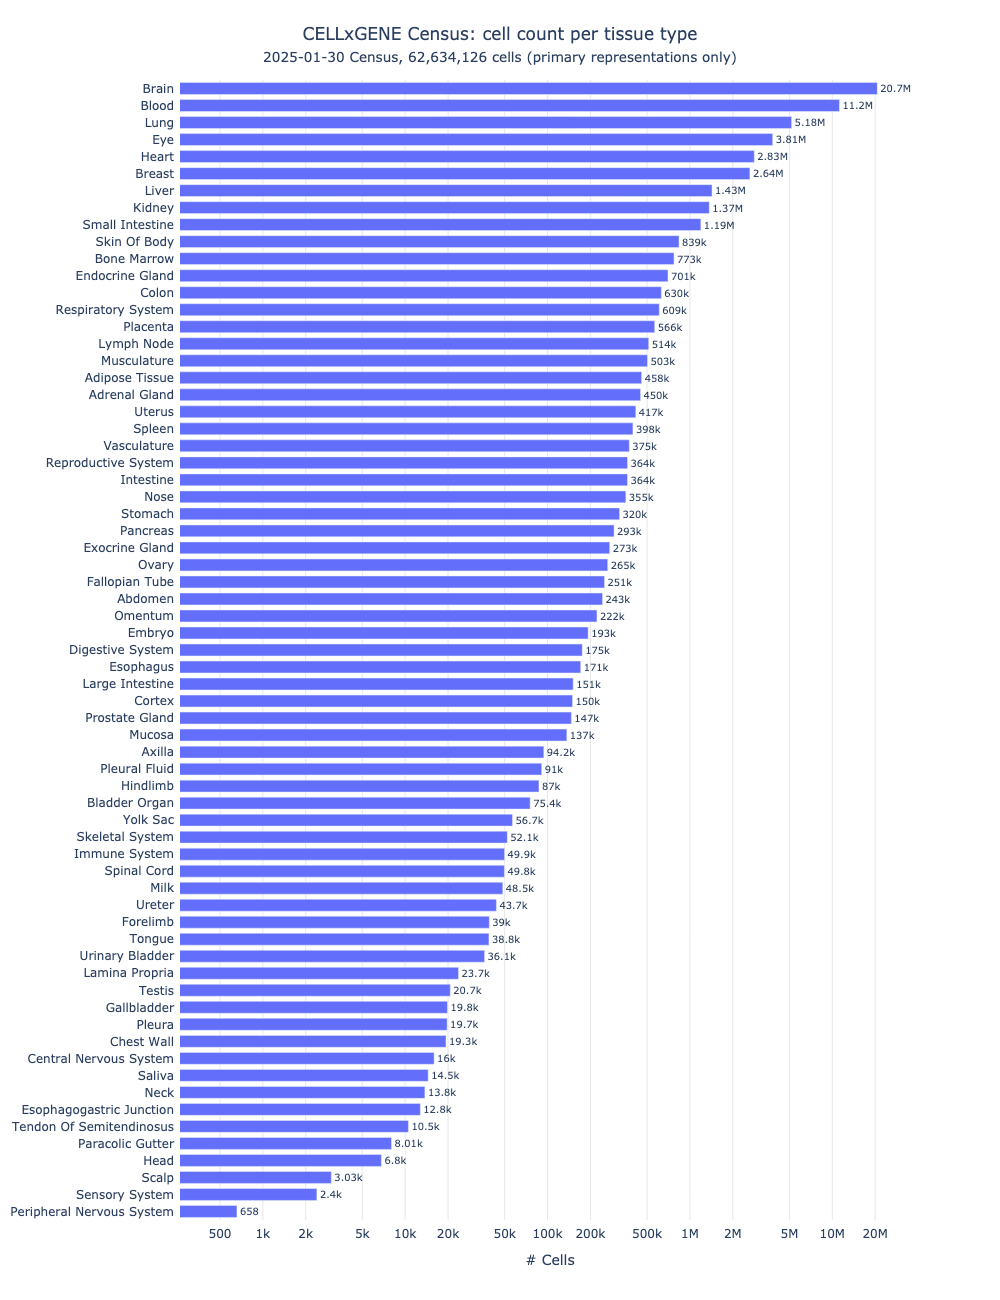

In [12]:
s = hsl[True].iloc[::-1].rename('# Cells')
s.index = s.index.to_series().apply(lambda t: t.title())
n_obs = int(s.sum())

def human_format(num):
    if num > 1e6:
        return f'{(num / 1e6):.3g}M'
    elif num > 1e3:
        return f'{(num / 1e3):.3g}k'
    else:
        return f'{num}'

plot(
    px.bar(
        s,
        orientation='h',
        log_x=True,
        labels={ 'value': s.name, },
    ).update_traces(
        text=[human_format(val) for val in s],
        textposition='outside',
    ),
    png_name='census-tissue-hist',
    name='census_tissue_hist_plot',
    title=[
        "CELLxGENE Census: cell count per tissue type",
        f"{lts} Census, {n_obs:,} cells (primary representations only)",
    ],
    w=1000, h=1300,
    legend=False,
    xgrid=f'#{"e7"*3}', ygrid=None,
    margin={ 't': 80, 'l': 180, 'pad': 5 },
    x=dict(
        tickformat='.0s',
        range=[np.log10(min(s)) - .4, np.log10(max(s)) + .3],
        title_standoff=20,
    ),
    y='',
    show='png',
    xaxis_automargin=False,
    yaxis_automargin=False,
    bargap=.3,
)